<center>
  <img width="128" src='wm.png'/>
  <h1> Anomaly Detection 
<center>

Outliers are data points that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set.

Outliers can occur in any distribution, but they often indicate either measurement error or that the population has a heavy-tailed distribution.

In the former case one wishes to discard them or use statistics that are robust to outliers, while in the latter case they indicate that the distribution has high skewness and that one should be very cautious in using standard statistical tools or intuitions.

We perform here an analysis of the outliers of a dataset representing trips performed by one elevator.

The columns of the csv files are as follow:

- ‘start_dt’ is the datetime when the trip started,
- ‘start_level’ is the level where the elevator trip started
- ‘end_level’ is the level  where the elevator trip ended
- ‘duration_s’ is the duration of the trip in seconds.

Trips are defined by the motion of the cabin, starting when the cabin leaves its current floor and ending when it stops again at another floor. 

We focus firstly on a general analysis, using visualization tools, then we detect outliers with statistical method and in the end we try to classify the outliers that could be anomalies in the measurment. 

The notebook is organized as follows:

- Initialization
- Summary and Exploration if Data
- Data Analysis
- Conclusions


# Initialization

In [70]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Summary and Exploration of Data

### Loading of data and first idea on shape and structure 

In [71]:
data=pd.read_csv('trips.csv') #Loading the data

In [72]:
data.shape #Looking at the shape of the data

(7403, 4)

In [73]:
data.head() #Showing the first 5 rows as a first idea

,start_dt,start_level,end_level,duration_s
0,2019-08-02 00:10:20.948,0.0,7.0,20.012
1,2019-08-02 00:10:55.319,7.0,5.0,7.702
2,2019-08-02 00:11:23.049,5.0,0.0,15.640
3,2019-08-02 01:28:13.277,0.0,5.0,15.659
4,2019-08-02 01:28:49.203,5.0,7.0,7.444


In [74]:
np.sum(data.isna()) #Checking if there are missing value (NaN)

start_dt       0
start_level    0
end_level      0
duration_s     0
dtype: int64

### Understanding the domain of the values in the dataset

In [6]:
data.start_dt.agg(['min','max']) #min e max value of the date

min    2019-08-02 00:10:20.948
max    2019-08-14 23:45:07.217
Name: start_dt, dtype: object

In [7]:
data.start_level.agg(['min','max']) #min e max value of the starting floor

min    0.0
max    7.0
Name: start_level, dtype: float64

In [8]:
data.end_level.agg(['min','max']) #min e max value of the ending floor

min    0.0
max    7.0
Name: end_level, dtype: float64

In [9]:
data.duration_s.agg(['min','max']) #min e max value of the duration of the trips

min       0.768
max    1429.428
Name: duration_s, dtype: float64

> **A first very naive signal of the existence of outlier values from the extreme values of the duration column !**

### Sorting, grouping and summary functions

In [10]:
data.sort_values(by='duration_s').head() #Sorting by duration

,start_dt,start_level,end_level,duration_s
6469,2019-08-13 14:10:29.246,5.0,7.0,0.768
6473,2019-08-13 14:14:57.497,5.0,7.0,0.769
6478,2019-08-13 14:18:46.168,7.0,5.0,2.578
6471,2019-08-13 14:11:41.372,5.0,7.0,3.330
6474,2019-08-13 14:14:58.266,7.0,5.0,3.856


In [11]:
data.sort_values(by=['start_level','end_level']).head() #Sorting by starting and ending level

,start_dt,start_level,end_level,duration_s
14,2019-08-02 04:28:33.437,0.0,1.0,6.677
36,2019-08-02 05:37:12.732,0.0,1.0,6.659
57,2019-08-02 06:16:35.750,0.0,1.0,6.675
64,2019-08-02 06:24:33.335,0.0,1.0,6.932
93,2019-08-02 06:48:54.669,0.0,1.0,6.678


> **Sorting and grouping can be useful to start having an idea  !**

In [12]:
data.groupby(['start_level','end_level']).duration_s.median().head() #Median computation of the duration grouped by start and end level 

start_level  end_level
0.0          1.0           6.9160
             2.0           8.9820
             3.0          11.2870
             4.0          13.3535
             5.0          15.6570
Name: duration_s, dtype: float64

In [13]:
data.groupby(['start_level','end_level']).duration_s.mean().head() #Mean computation of the duration grouped by start and end level 

start_level  end_level
0.0          1.0           6.820483
             2.0           9.071482
             3.0          11.294657
             4.0          13.468034
             5.0          15.697275
Name: duration_s, dtype: float64

### First Visual idea of data

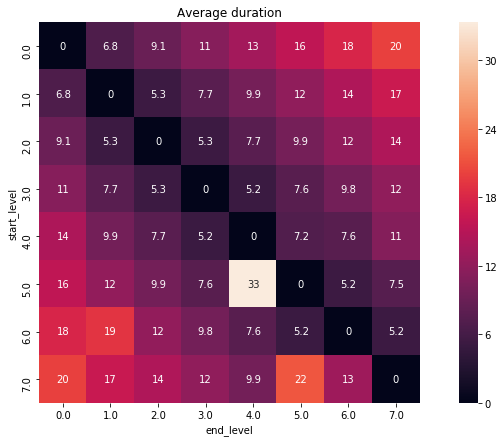

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average duration")

piv = pd.pivot_table(data, values="duration_s",index=["start_level"], columns=["end_level"], fill_value=0)
ax = sns.heatmap(piv, square=True,annot=True)

> **The heatmap is not the best tools for recognize outliers, but as part of a first analysis it can be useful to look at the anomalies. In this case the presence of very high values in the duration shift the average to an anomalous (are they ?) value ! Let's be more precise in the next section**

# Data Analysis

Since the purpose of this work is recognize and remove, if they are, outliers, we focus on doing this. We can it do by detecting them with visualization tools and mathematical tools. In both method we have to firstly think which are the meaningful variables we should use. That means we have to, first of all, recognize the variables that give us more information on the anomalous beaviour of the trip, and then the features that can affect these variables. What we are looking for is then an anomalous affection of the behaviour of the trip. 

In our case we choose as a meaningful variable the duration of the trip. As features we use the start and ending floor of each trip. Since we are looking for a anomalous behaviour of a data in a statistical set, using statistical method we should firstly recognize which are the features that make a subset independent from another one and without any kind of systematic that can spoil the method. 

We consider a statistical subset of the total set of trips, every trip starting from the i-floor and ending in the j-floor. In this way every trip in a given subset will have the same floor distance and same direction. In principle we should use also the time and date as a discriminating variable (for instance duration of trips can depend on the number of people inside that in turn could depend on the hour and date, let's think for example to a elevator in a subway station) but since we are pretty blind on the kind of elevator we don't consider this feature in our analysis.

We start by considering visualization tools

In [15]:
#We define a function that add a column representing the floor distance and the direction of the trip, and trasform in integer the values of the floor numbers
def func(row):
    
    row['floor_distance'] = row.end_level - row.start_level #add the column 'floor_distance'
    row.start_level = int(row.start_level) #transform in integer
    row.end_level = int(row.end_level) #transform in integer
    
    if row.floor_distance <= 0 :  #add the column 'direction'
        row['direction'] = 'down' 
    else:
        row['direction'] = 'up'
    
    row.floor_distance = int(abs(row.floor_distance))
    
    return row

In [16]:
df=data.apply(func, axis='columns') #We apply the function above and we define a new dataframe df to modify and analyse such that the starting one remain untouched

In [17]:
df.head() #head of the transformed dataset

,start_dt,start_level,end_level,duration_s,floor_distance,direction
0,2019-08-02 00:10:20.948,0,7,20.012,7,up
1,2019-08-02 00:10:55.319,7,5,7.702,2,down
2,2019-08-02 00:11:23.049,5,0,15.640,5,down
3,2019-08-02 01:28:13.277,0,5,15.659,5,up
4,2019-08-02 01:28:49.203,5,7,7.444,2,up


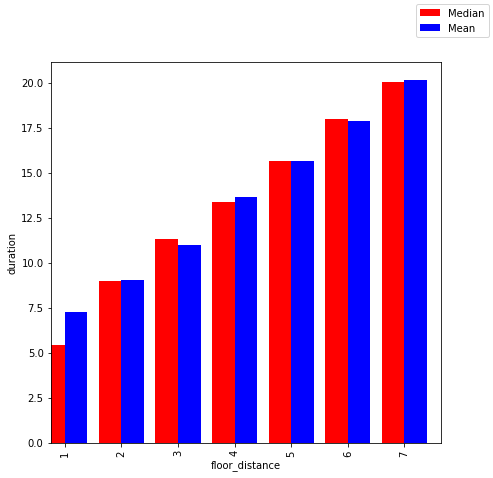

In [18]:
#We plot the mean value and the median for each floor distance subset to see the discrepance between the two
fig1 = plt.figure() 
ax = fig1.add_subplot(111) 

df.groupby(['floor_distance'])['duration_s'].median().plot(kind='bar', color='red', ax=ax, width=0.4, position=1,figsize=(7,7))
df.groupby(['floor_distance'])['duration_s'].mean().plot(kind='bar', color='blue', ax=ax, width=0.4, position=0,figsize=(7,7))
fig1.legend(["Median", "Mean"])
ax.set_ylabel('duration')

plt.show()

### BoxPlot(s) for Outliers

BoxPlots are particular plot showing the interquartile range and the range of value delimiting the outliers with the so called whiskers. The value outside the boxplot whiskers are the outliers. The figure above explain better the meaning of the plot:

<div>
  <img width="300" src='box.png'/> 
</div>

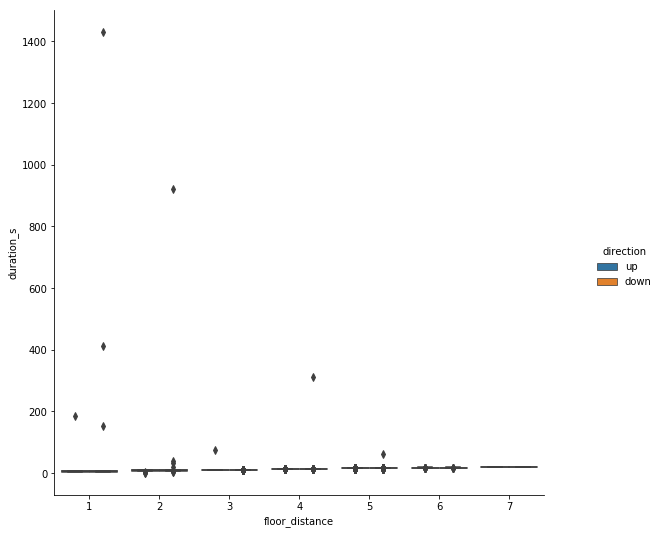

In [19]:
#BoxPlot showing outliers
fig2=sns.catplot(data=df,y='duration_s',x='floor_distance',hue='direction',kind='box',showfliers=True)
fig2.fig.set_size_inches(10,8)

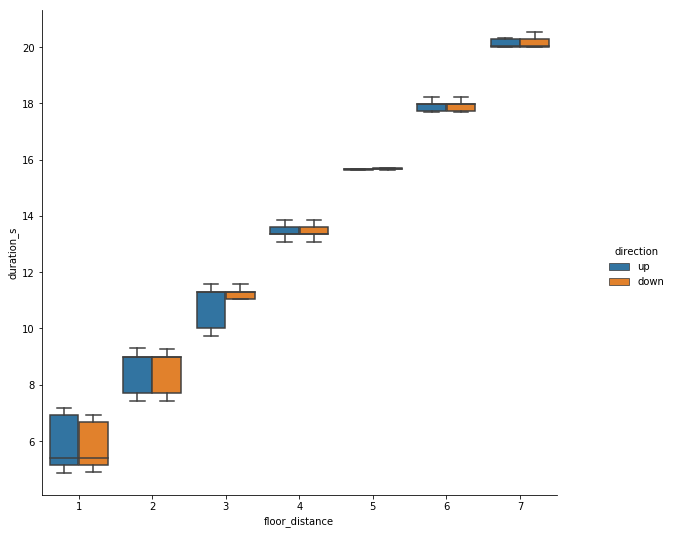

In [20]:
#BoxPlot without showing outliers
fig2=sns.catplot(data=df,y='duration_s',x='floor_distance',hue='direction',kind='box',showfliers=False)
fig2.fig.set_size_inches(10,8)

### Removing Outliers with IQR

The IQR test is basically the mathematical traduction of what the boxplot shows. It keeps all the values inside the the Interquartile range and classifies the other as Outliers. An important step is recognize the meaningful features useful to compute the quartiles. We define 2 function that identitfy the index of the outliers. The first one, is considering a subset of identical event as the trip starting at the ith-floor and ending at the jth-floor. The second funciton, more coarse grain, is considering as identical trips just by grouping by floor_distance forgetting about the starting and ending point.

In [21]:
#First function
def find_outlier_index(data):
    
    indX=[]
    
    
    for i in range(min(data.start_level),max(data.start_level)+1):
        for j in range(min(data.end_level),max(data.end_level)+1):
            if i != j:
                qmax=data.loc[(data.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.75).loc[abs(j-i),'duration_s']+1.5*(data.loc[(data.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.75).loc[abs(j-i),'duration_s']-data.loc[(df.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.25).loc[abs(j-i),'duration_s'])
                qmin=data.loc[(data.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.25).loc[abs(j-i),'duration_s']-1.5*(data.loc[(data.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.75).loc[abs(j-i),'duration_s']-data.loc[(df.start_level==i) & (data.end_level==j)].groupby(['floor_distance']).quantile(0.25).loc[abs(j-i),'duration_s'])
                c1=data.start_level==i #First contraints
                c2=data.end_level==j #Second contraints
                c3=data.duration_s > qmax #Third contraints
                c4=data.duration_s < qmin #Fourth contraints
                ind_event=data.index[(c1) & (c2)] #Intersection between the first two constraints
                ind_max=data.index[c3] #Index of the third constraint
                ind_min=data.index[c4] #Index of the fourth constraint
                ind1=list(set(ind_event).intersection(ind_max)) #Intersection of ind_event and the third constraint
                ind2=list(set(ind_event).intersection(ind_min)) #Intersection of ind_event and the fourth constraint
                indX.extend(ind1) #Union
                indX.extend(ind2) #Union
    
    return indX

In [22]:
#Second function
def find_outlier_index_2(data):
    
    indX=[]
    
    
    for i in range(min(data.start_level),max(data.start_level)+1):
        qmax=data.loc[data.floor_distance==i].quantile(0.75).loc['duration_s']+1.5*(data.loc[data.floor_distance==i].quantile(0.75).loc['duration_s']-data.loc[data.floor_distance==i].quantile(0.25).loc['duration_s'])
        qmin=data.loc[data.floor_distance==i].quantile(0.25).loc['duration_s']-1.5*(data.loc[data.floor_distance==i].quantile(0.75).loc['duration_s']-data.loc[data.floor_distance==i].quantile(0.25).loc['duration_s'])
        c1=data.floor_distance==i
        c3=data.duration_s > qmax 
        c4=data.duration_s < qmin
        ind_event=data.index[c1]
        ind_max=data.index[c3]
        ind_min=data.index[c4]
        ind1=list(set(ind_event).intersection(ind_max))
        ind2=list(set(ind_event).intersection(ind_min))
        indX.extend(ind1)
        indX.extend(ind2)
    
    return indX

In [23]:
outliers=df.iloc[find_outlier_index(df)] #Outliers found with the first function
outliers_2=df.iloc[find_outlier_index_2(df)] #Outliers found with the second function

In [24]:
outliers.shape, outliers_2.shape #Shape of the 2 sets of Outliers 

((591, 6), (527, 6))

In [25]:
df_clean=df.drop(find_outlier_index(df)) #Clean dataset 1
df_clean_2=df.drop(find_outlier_index_2(df)) #Clean dataset 2

### Visualizing cleaned dataset

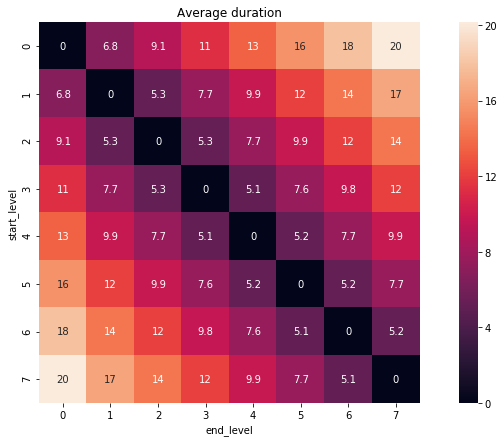

In [26]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average duration")

piv = pd.pivot_table(df.drop(find_outlier_index(df)), values="duration_s",index=["start_level"], columns=["end_level"], fill_value=0)
ax = sns.heatmap(piv, square=True,annot=True)

### Outliers as Anomalies 

In this section we try to use scikit libraries and method of clustering algorithm to refine the analysis and try to isolate the subset of the outliers that have a genuinly anomalous nature and are not coming from a long tailed distribution. These value are supposed to be anomaly in the detection or some other systematic error decoupled form the statistic of the data. 
Despite the large number of clustering method we decide to use the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) method. It is part of the unsupervised methods and it works as follow:


- Randomly select a point not already assigned to a cluster or designated as an outlier. Determine if it’s a core point by seeing if there are at least min_samples points around it within epsilon distance.

- Create a cluster of this core point and all points within epsilon distance of it (all directly reachable points).
Find all points that are within epsilon distance of each point in the cluster and add them to the cluster.

- Find all points that are within epsilon distance of all newly added points and add these to the cluster. Rinse and repeat.

In [38]:
from sklearn.cluster import DBSCAN

In [65]:
#Defining the model and its parameters, and the features we use in the cluster algoritmh
model = DBSCAN(eps=2,min_samples = 4).fit(outliers[['duration_s','start_level','end_level']])

In [66]:
#Apply the model to our dataset
anomalies=outliers[model.labels_ == -1].sort_values(by=['duration_s','start_level'])

In [67]:
anomalies.shape #Anomaly dataset shape

(17, 6)

In [68]:
anomalies #List of candidate anomalous values

,start_dt,start_level,end_level,duration_s,floor_distance,direction
6469,2019-08-13 14:10:29.246,5,7,0.768,2,up
6473,2019-08-13 14:14:57.497,5,7,0.769,2,up
6471,2019-08-13 14:11:41.372,5,7,3.330,2,up
5479,2019-08-09 18:23:02.129,7,3,11.817,4,down
6196,2019-08-12 08:19:54.229,6,2,12.310,4,down
4947,2019-08-09 09:00:59.138,7,3,12.312,4,down
6472,2019-08-13 14:11:44.702,7,5,18.524,2,down
1796,2019-08-05 10:49:26.290,2,0,31.269,2,down
6476,2019-08-13 14:16:38.618,7,5,39.783,2,down
6463,2019-08-12 12:20:37.055,6,1,63.126,5,down


In [69]:
anomalies.sort_values(by='start_dt') #List of candidate anomalous values sorted by date in order for looking of some problem in a specific hour or date

,start_dt,start_level,end_level,duration_s,floor_distance,direction
1791,2019-08-05 10:41:55.709,4,0,310.370,4,down
1796,2019-08-05 10:49:26.290,2,0,31.269,2,down
4947,2019-08-09 09:00:59.138,7,3,12.312,4,down
5479,2019-08-09 18:23:02.129,7,3,11.817,4,down
6196,2019-08-12 08:19:54.229,6,2,12.310,4,down
6459,2019-08-12 11:44:00.784,7,5,921.087,2,down
6460,2019-08-12 12:08:10.882,5,4,153.807,1,down
6461,2019-08-12 12:11:50.395,4,7,75.200,3,up
6462,2019-08-12 12:13:07.900,7,6,413.229,1,down
6463,2019-08-12 12:20:37.055,6,1,63.126,5,down


# Conclusion

From the analysis with IQR test we saw that the a large number of data in the dataset are classified as outliers. As highlighted at the beggining of the notebook once we identified the outliers is pretty an hard task to decide if it belongs to a tail of a statistical distribution or it is an error of measurment in which case has to be excluded from the set. We could refine the statistical test by keeping a larger part of the tail or we can use clustering method.


Clustering model can be useful to address the latter case but they are very dependent on the parameters we chose. In particular changing the epsilon or the min_samples points can affect the results significanlty. 

